In [1]:
import pandas as pd
import os

# mac.osで動かすためのおまじない
os.environ['KMP_DUPLICATE_LIB_OK']='True'

base_dir = "mini_pictures_2"
train_dir = os.path.join(base_dir,"train")
valid_dir = os.path.join(base_dir,"valid")
test_dir = os.path.join(base_dir,"test")
mini_metadata_2 = pd.read_csv('mini_metadata_2.csv',index_col=0)
classes = list(mini_metadata_2["make_model"].value_counts().index)
classes = sorted(classes)
classes_num = len(mini_metadata_2.groupby("make_model"))
print(classes)
print(classes_num)
# mini_metadata.groupby("make_model").nunique()
print(mini_metadata_2["make_model"].value_counts())

['Audi-a5', 'BMW-1-series', 'Honda-pilot', 'Lexus-is-250', 'MINI-countryman', 'Mitsubishi-outlander', 'Nissan-rogue-select', 'Subaru-outback', 'Subaru-xv-crosstrek', 'Volvo-xc60']
10
MINI-countryman         11
Mitsubishi-outlander    10
Honda-pilot             10
BMW-1-series             9
Audi-a5                  9
Nissan-rogue-select      8
Lexus-is-250             8
Subaru-outback           8
Volvo-xc60               7
Subaru-xv-crosstrek      6
Name: make_model, dtype: int64


In [14]:
from keras import layers
from keras import models

# 特徴を抽出
# model.add(layers.Conv2D(フィルターの種類の数, (フィルターの大きさ), activation='活性化関数',
#                input_shape=ここの中身はいじらない(縦, 横, 色の数(奥行き))))
model_3= models.Sequential()
# denseは全結合、情報を圧縮する。最初の引数は圧縮した後の数
model_3.add(layers.Conv2D(32, (3, 3), activation='relu',
                       input_shape=(256, 256, 3)))
model_3.add(layers.Flatten())
model_3.add(layers.Dense(classes_num, activation='softmax'))

In [15]:
model_3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 254, 254, 32)      896       
_________________________________________________________________
flatten_1 (Flatten)          (None, 2064512)           0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)                20645130  
Total params: 20,646,026
Trainable params: 20,646,026
Non-trainable params: 0
_________________________________________________________________


In [16]:
from keras import optimizers

# categorical_crossentropy,lr=学習率
# entropyは情報の不確かさの尺度で小さいほど、確かっぽい感じがする
# entropyを使うことで不確かが数値で計算ができるのがよき
# これをめちゃくちゃ小さくできれば多分確からしいからそこを目指したい
model_3.compile(loss='categorical_crossentropy',
             optimizer=optimizers.Adam(lr=1e-4),
             metrics=['acc'])

In [17]:
from keras.preprocessing.image import ImageDataGenerator
#すべての画像を1/255スケーリング(大きさではなくて光の大きさ)
# deeplearningは計算して重みの更新をするから使う数値は小さい方が良い
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

#flow_from_directoryでは、categoricalのラベリングにclassesを参照して、ディレクトリ名から自動的にone-hotエンコードされる
# ここは頑張りましょう、flow_from_directoryと検索したり、本読んだり
train_generator = train_datagen.flow_from_directory(
    train_dir,               #ターゲットディレクトリ
    target_size=(256, 256),  #すべての画像サイズを256*256に変換
    batch_size=32,           #バッチサイズ
    class_mode='categorical',
    classes=classes)#categorical_crossentropyを使用するため多クラスラベルが必要

validation_generator = test_datagen.flow_from_directory(
    valid_dir,               #ヴァリデーションディレクトリ
    target_size=(256, 256),  #すべての画像サイズを256*256に変換
    batch_size=32,           #バッチサイズ、重りの更新をするときになんかごとに重りを変更するか的な
    class_mode='categorical',
    classes=classes)#categorical_crossentropyを使用するため多クラスラベルが必要




Found 845 images belonging to 10 classes.
Found 257 images belonging to 10 classes.


In [21]:
history = model_3.fit_generator(train_generator,
                             steps_per_epoch=845//32,
                             epochs=30,
                             validation_data=validation_generator,
                             validation_steps=257//32)
import json
with open('2_dense_mini_2_history.json', 'w') as f:
    json.dump(history.history, f)

Epoch 1/30
26/26 [==============================] - 53s 2s/step - loss: 12.7515 - acc: 0.1116 - val_loss: 13.5285 - val_acc: 0.1422
Epoch 2/30
26/26 [==============================] - 48s 2s/step - loss: 11.8196 - acc: 0.1853 - val_loss: 11.4782 - val_acc: 0.1689
Epoch 3/30
26/26 [==============================] - 48s 2s/step - loss: 11.4339 - acc: 0.2476 - val_loss: 11.9998 - val_acc: 0.2444
Epoch 4/30
26/26 [==============================] - 52s 2s/step - loss: 11.1828 - acc: 0.2967 - val_loss: 11.5119 - val_acc: 0.2711
Epoch 5/30
26/26 [==============================] - 52s 2s/step - loss: 11.2582 - acc: 0.2969 - val_loss: 11.6099 - val_acc: 0.2622
Epoch 6/30
26/26 [==============================] - 54s 2s/step - loss: 11.1150 - acc: 0.3099 - val_loss: 11.5634 - val_acc: 0.2756
Epoch 7/30
26/26 [==============================] - 53s 2s/step - loss: 11.1429 - acc: 0.3089 - val_loss: 11.5365 - val_acc: 0.2852
Epoch 8/30
26/26 [==============================] - 49s 2s/step - loss: 11.2

In [22]:
import json
f = open('2_dense_mini_2_history.json', 'r')
history = json.load(f)
f.close()

In [23]:
model_3.save("2_dense_mini_2.h5")

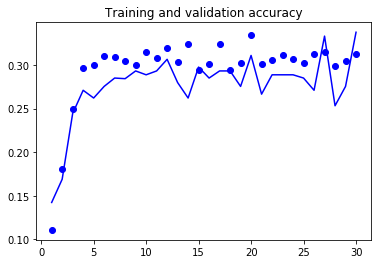

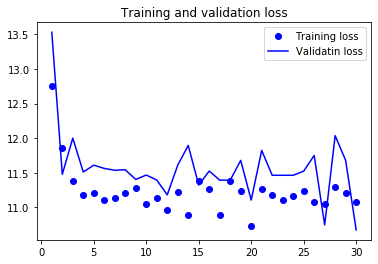

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history['acc']
val_acc = history['val_acc']
loss = history['loss']
val_loss = history['val_loss']

epochs = range(1,len(acc)+1)

#正解率をプロット
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')



#損失値をプロット
plt.figure()# 2枚目の図の下地
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validatin loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()